# Spotify Charts – Feature Exploration

This notebook loads the processed Spotify tracks dataset and uses the `charts` module
(PCA + clustering helpers) to create statistical and fancy visualisations of the audio features.


### Load the data and the functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
from data_visualisation import get_id_list
warnings.filterwarnings('ignore')

from charts import plot_pca_scatter, plot_clustered_pca
from data_visualisation import (
    load_data,
    get_id_list,
    get_track_appearances,
    calculate_track_lifecycle,
    plot_track_rankings,
    plot_time_series,
    plot_weekly_trends,
    plot_track_lifecycle,
    plot_audio_feature_distributions,
    plot_streams_heatmap,
    plot_streams_vs_features,
    plot_correlation_heatmap,
    get_stream_correlations,
    engineer_ml_features,
    split_train_test,
    train_stream_prediction_models,
    plot_prediction_results,
    prepare_classification_data,
    train_classification_models,
    plot_classification_results,
    compare_models,
    plot_feature_importance,
    plot_roc_curves,
    plot_best_confusion_matrix,
    prepare_longevity_data,
    plot_longevity_distribution,
    prepare_longevity_groups,
    plot_longevity_feature_comparison,
    plot_longevity_correlations,
    plot_longevity_scatter_plots,
    plot_longevity_clustering,
    plot_longevity_curves,
    plot_longevity_ml_results,
    print_summary_insights,
)

sns.set_theme(style="whitegrid")

# DATA LOADING

# Path to the gold features file
DATA_PATH = "data/gold/"

# Load the data
songs = load_data(DATA_PATH)

# Quick overview
songs.head()

,track_id,artist_names,track_name,source,streams,week_date,duration_ms,explicit,artists,id_artists,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,3KkXRkHbMCARz0aVfEt68P,"Post Malone, Swae Lee",Sunflower - Spider-Man: Into the Spider-Verse,Universal Records,34579416,2019-01-17,158040.0,0.0,"['Post Malone', 'Swae Lee']","['246dkjvS1zLTtiykXe5h60', '1zNqQNIdeOUZHb8zbZ...",...,2.0,-5.574,1.0,0.0466,0.556,0.000000,0.0703,0.913,89.911,4.0
1,7xQAfvXzm3AkraOtGPWIZg,Post Malone,Wow.,Republic Records,29944242,2019-01-17,149547.0,1.0,['Post Malone'],['246dkjvS1zLTtiykXe5h60'],...,11.0,-7.359,0.0,0.2080,0.136,0.000002,0.1030,0.388,99.960,4.0
2,3e9HZxeyfWwjeyPAMmWSSQ,Ariana Grande,"thank u, next",Republic Records,27807232,2019-01-17,207320.0,1.0,['Ariana Grande'],['66CXWjxzNUsdJxJ2JdwvnR'],...,1.0,-5.634,1.0,0.0658,0.229,0.000000,0.1010,0.412,106.966,4.0
3,5p7ujcrUXASCNwRaWNHR1C,Halsey,Without Me,Capitol Records,27138512,2019-01-17,201661.0,1.0,['Halsey'],['26VFTg2z8YR0cCuwLzESi2'],...,6.0,-7.050,1.0,0.0705,0.297,0.000009,0.0936,0.533,136.041,4.0
4,5iwz1NiezX7WWjnCgY5TH4,"Pedro Capó, Farruko",Calma - Remix,Sony Music Latin,22816097,2019-01-17,238200.0,0.0,"['Pedro Capó', 'Farruko']","['4QVBYiagIaa6ZGSPMbybpy', '329e4yvIujISKGKz1B...",...,11.0,-4.218,0.0,0.0524,0.323,0.000000,0.1430,0.761,126.899,4.0


# Time-Series Analysis and Track Rankings


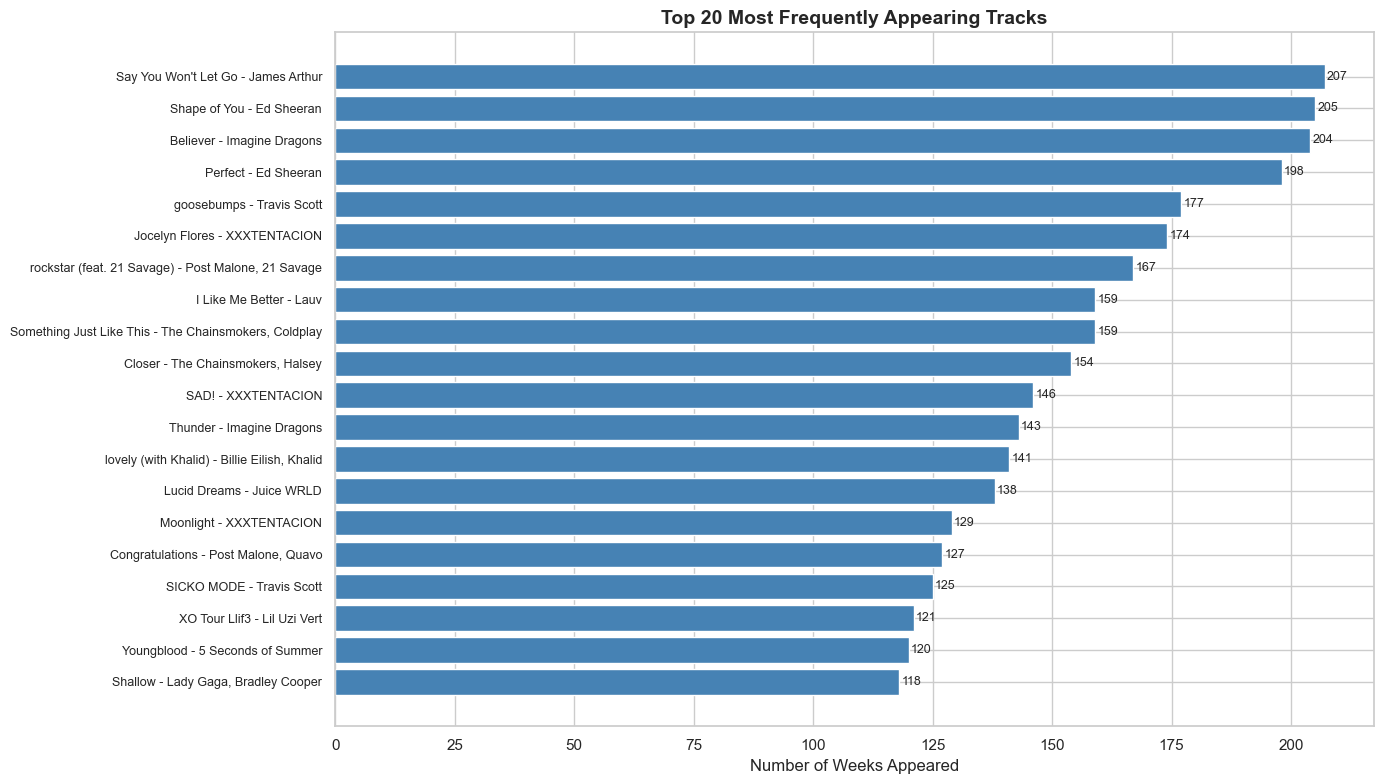


Total unique tracks: 2003
Total track-week combinations: 34591

Top 5 tracks by appearance count:
                track_name     artist_names  appearance_count   avg_streams
1507  Say You Won't Let Go     James Arthur               207  6.584077e+06
1947          Shape of You       Ed Sheeran               205  1.293260e+07
218               Believer  Imagine Dragons               204  7.659177e+06
241                Perfect       Ed Sheeran               198  7.913984e+06
1696            goosebumps     Travis Scott               177  6.308724e+06


In [2]:
# Ranking of most appearing track IDs
track_appearances = get_track_appearances(songs)
top_tracks = plot_track_rankings(track_appearances, top_n=20)

print(f"\nTotal unique tracks: {songs['track_id'].nunique()}")
print(f"Total track-week combinations: {len(songs)}")
print(f"\nTop 5 tracks by appearance count:")
print(top_tracks[['track_name', 'artist_names', 'appearance_count', 'avg_streams']].head())


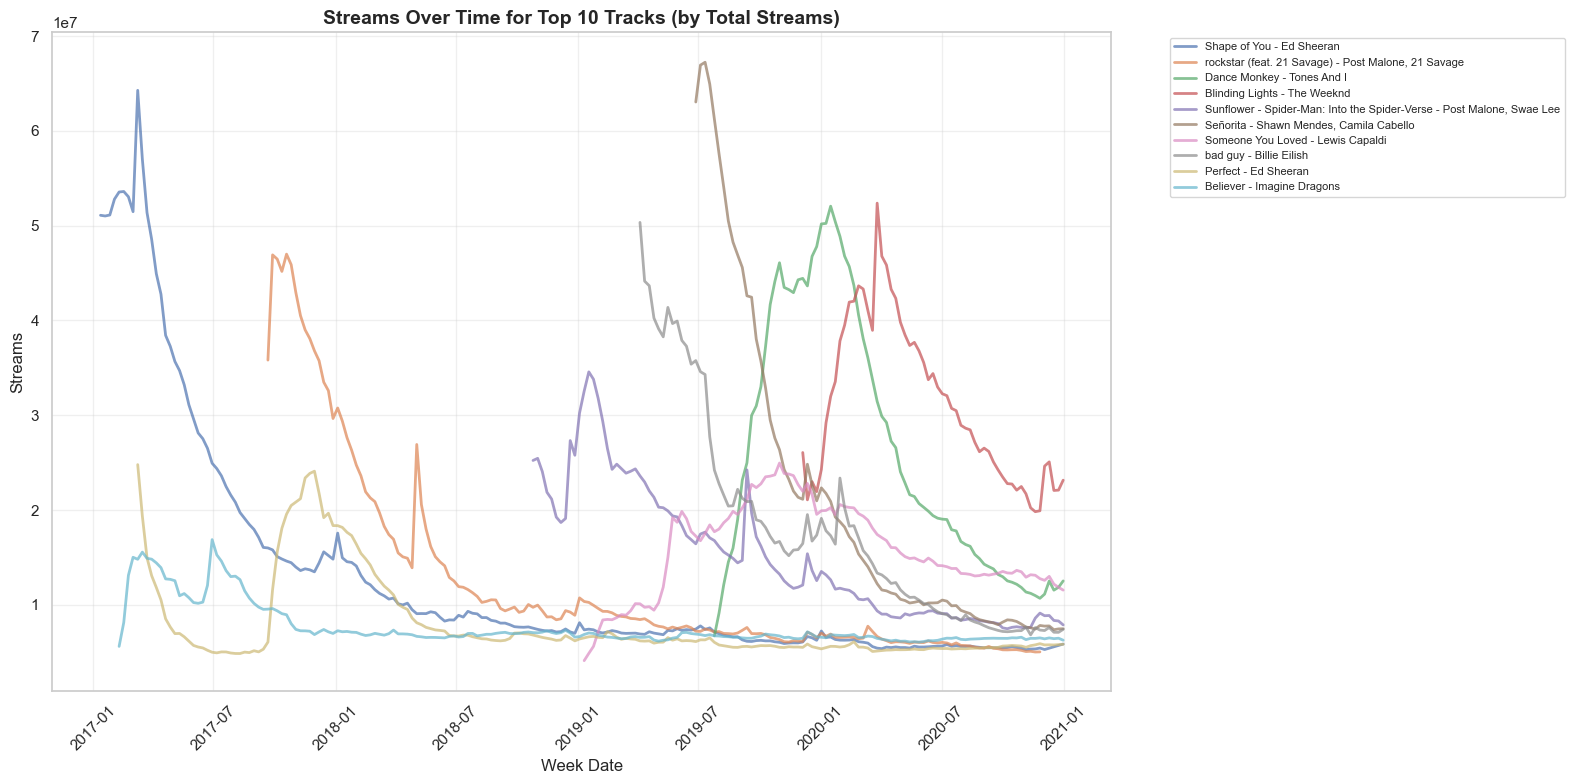

In [3]:
# Time series: Streams per track ID over weeks
plot_time_series(songs, track_appearances, top_n=10, by='total_streams')


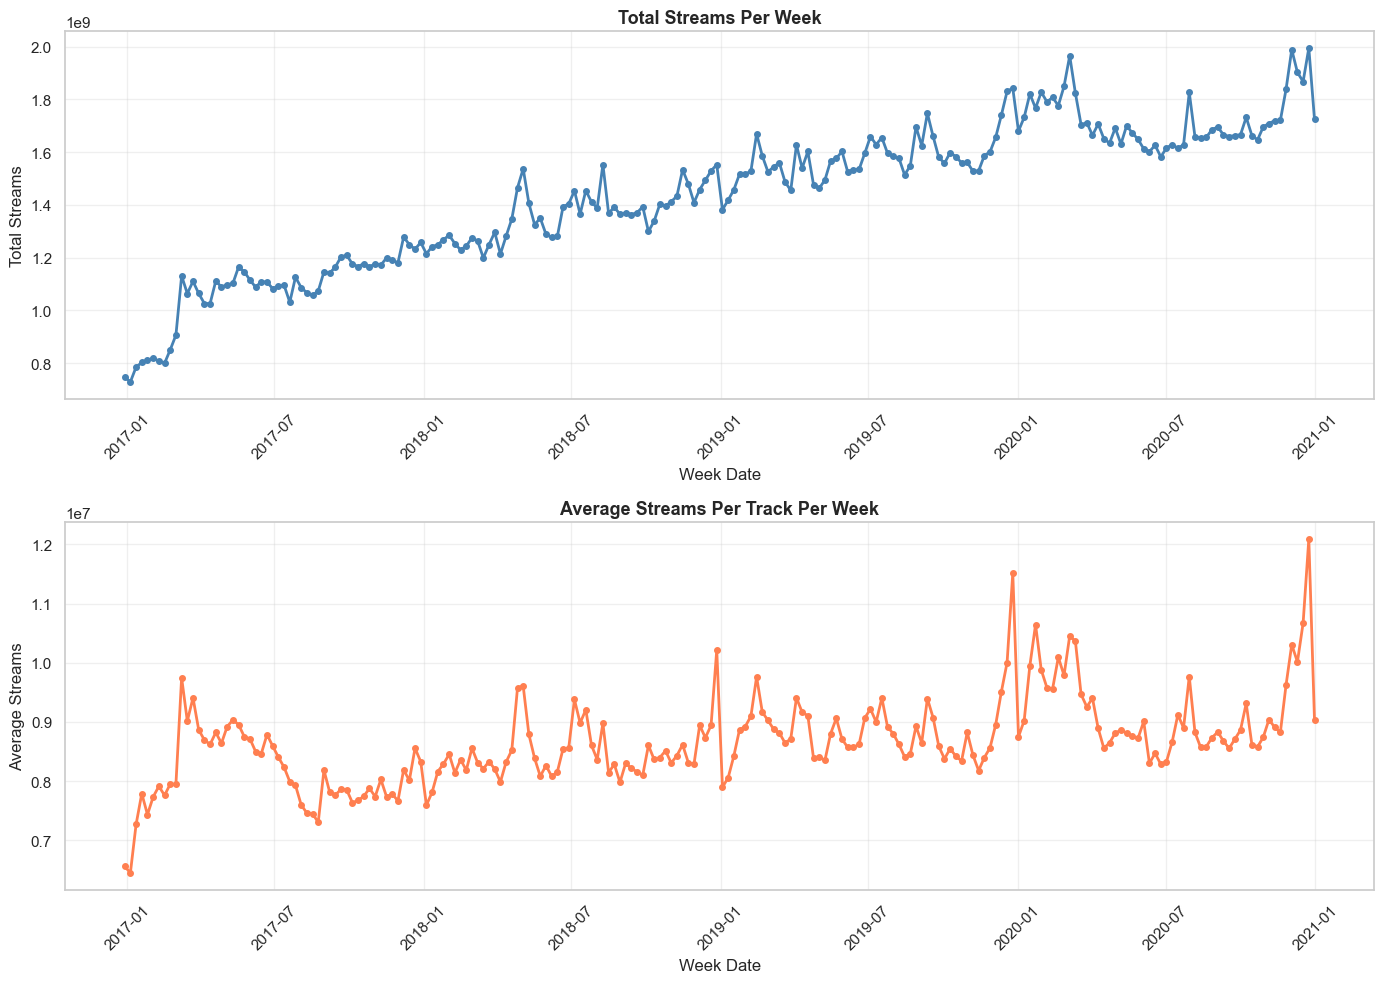

In [4]:
# Aggregate trends: Total and average streams per week
weekly_stats = plot_weekly_trends(songs)


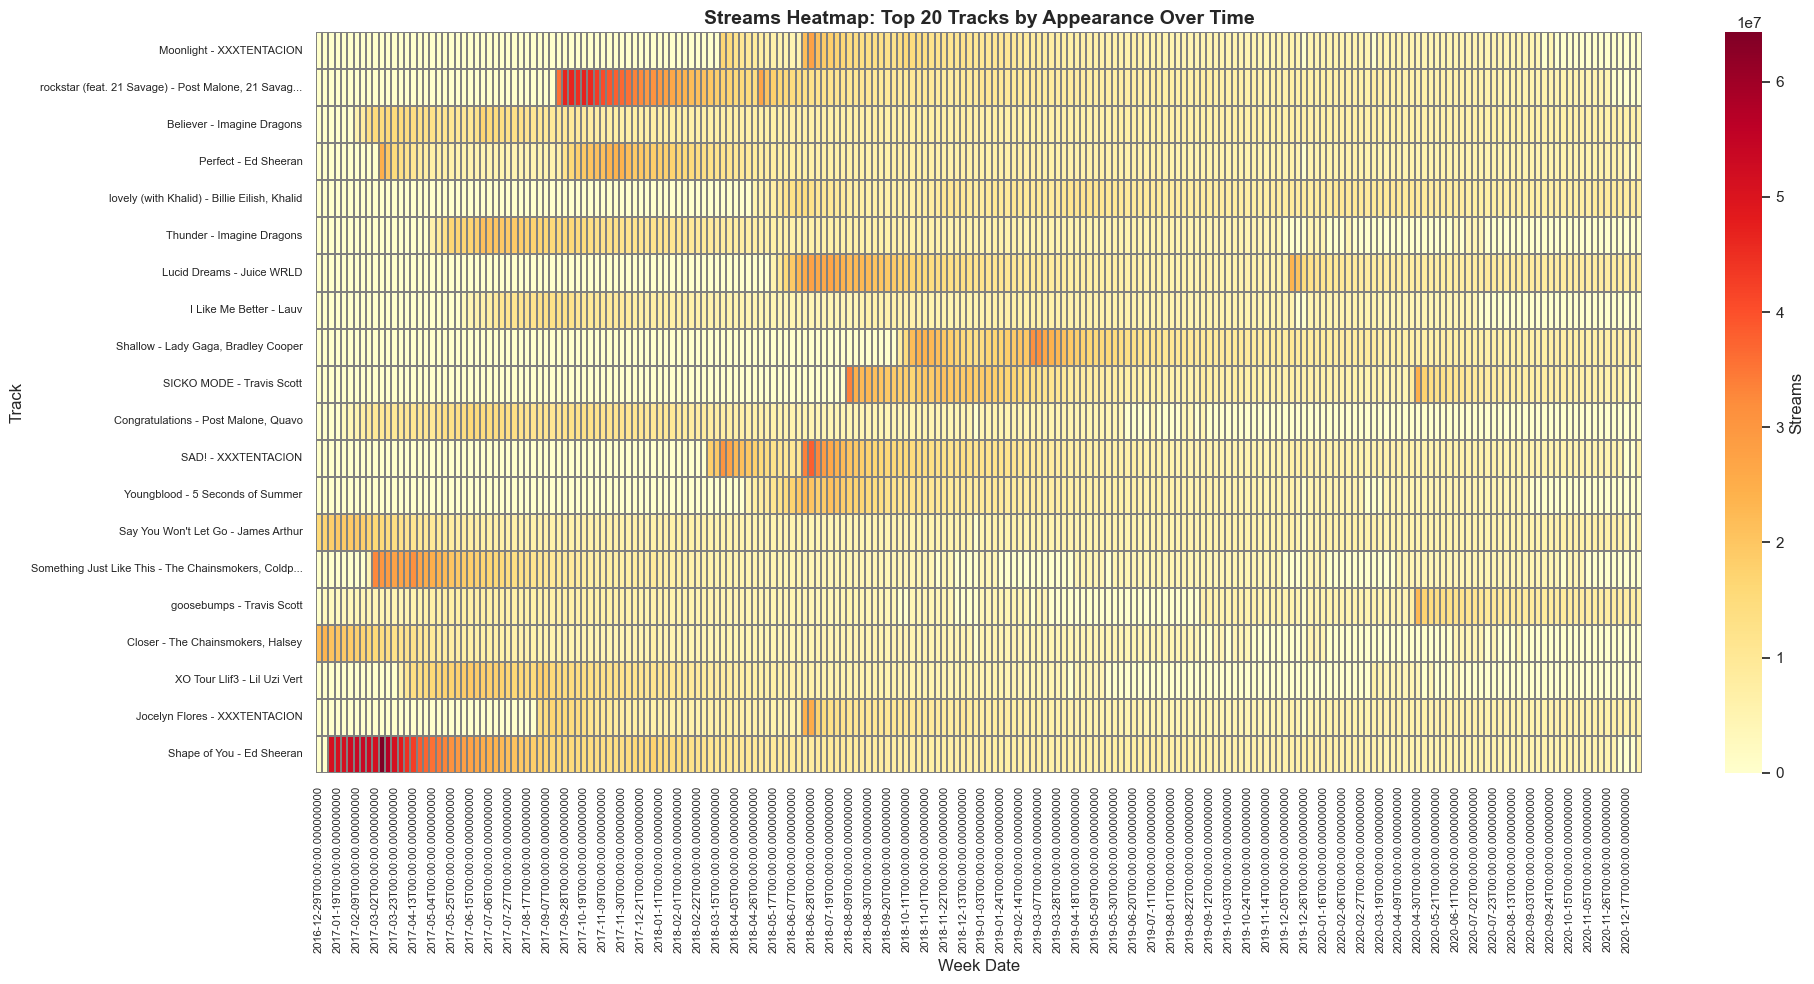

In [5]:
# Heatmap: Streams by track and week (for top 20 tracks by appearance)
plot_streams_heatmap(songs, track_appearances, top_n=20)


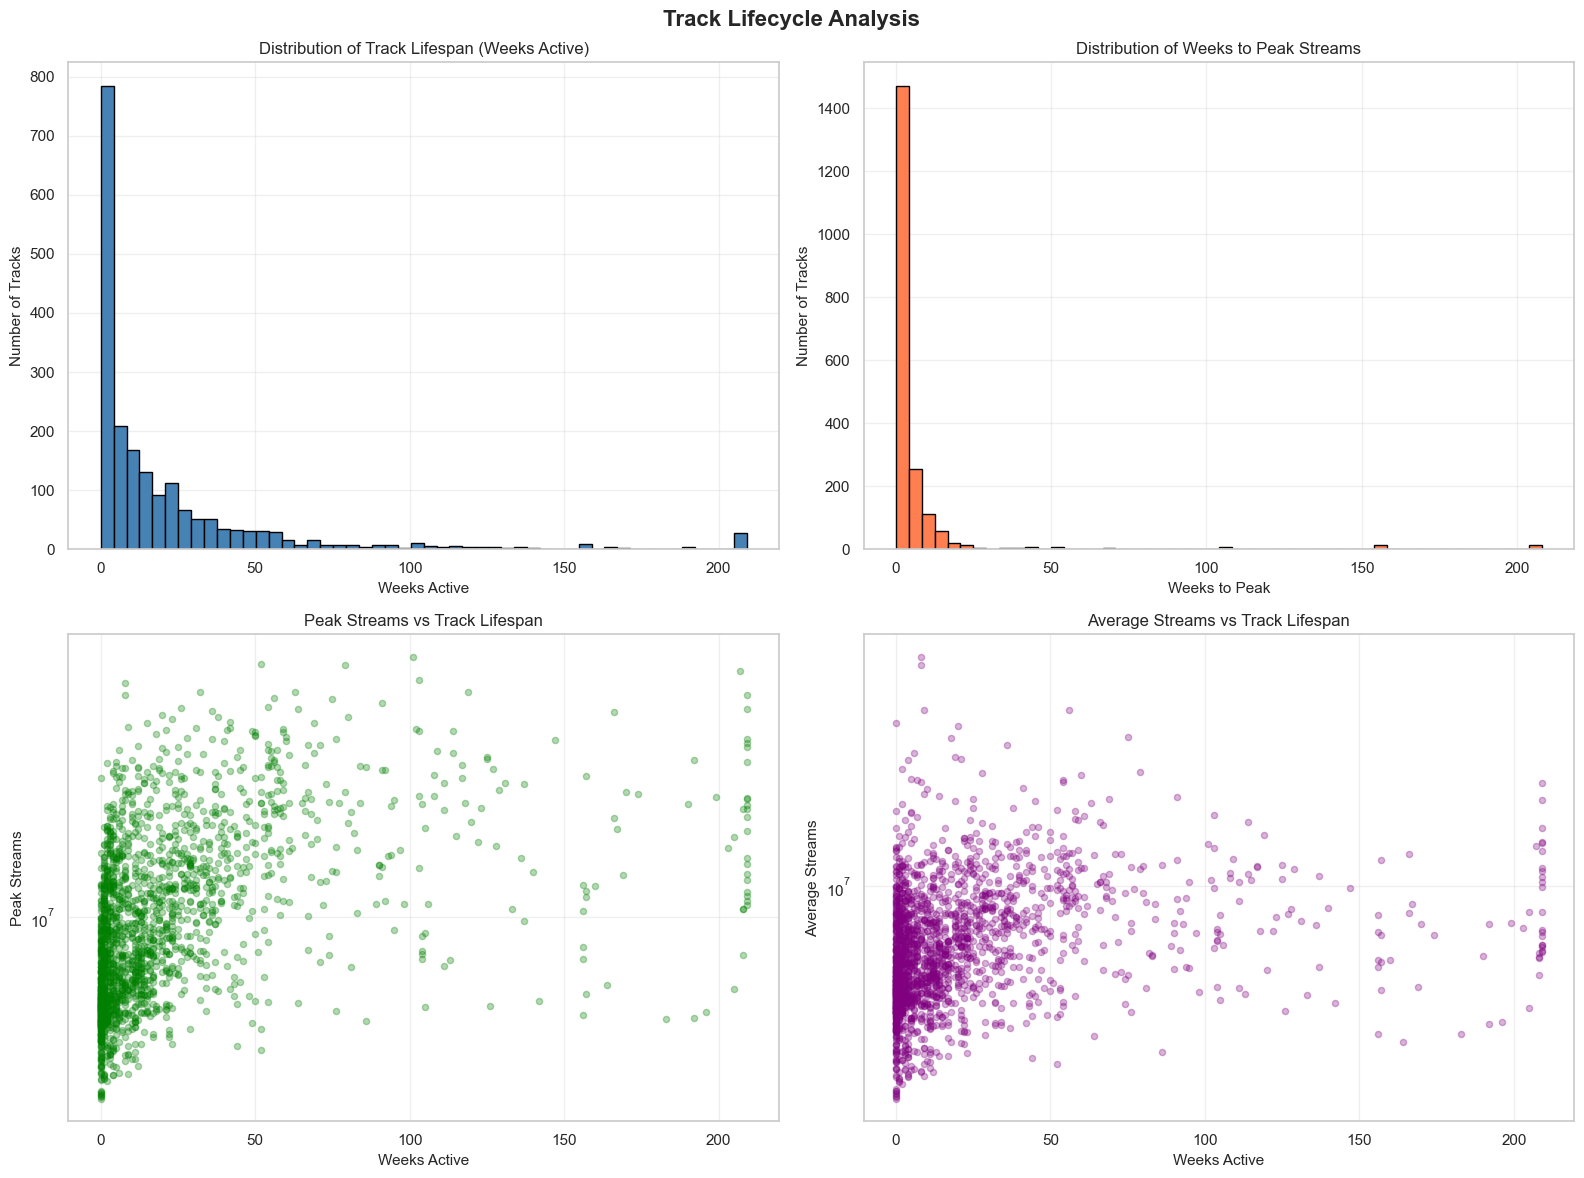


Track lifecycle statistics:
Average weeks active: 22.0
Median weeks active: 9.0
Average weeks to peak: 6.9
Median weeks to peak: 1.0


In [6]:
# Track lifecycle analysis: First appearance, peak, decline
track_lifecycle = calculate_track_lifecycle(songs)
plot_track_lifecycle(track_lifecycle)


## Chart Longevity Analysis

This section analyzes what makes songs last longer on the charts.

### A. Define Target Variable: Chart Longevity

We measure "lasting on the charts" using:
- **Weeks on Chart** (appearance_count): Number of weeks a track appears
- **Peak Rank**: Best position achieved
- **Stability Score**: Standard deviation of ranking (lower = more stable)

In [7]:
# Prepare longevity data
longevity_data = prepare_longevity_data(songs, track_appearances)

print(f"Total tracks analyzed: {len(longevity_data)}")
print(f"Average weeks on chart: {longevity_data['weeks_on_chart'].mean():.1f}")
print(f"Median weeks on chart: {longevity_data['weeks_on_chart'].median():.1f}")
print(f"Max weeks on chart: {longevity_data['weeks_on_chart'].max()}")


Total tracks analyzed: 2003
Average weeks on chart: 17.3
Median weeks on chart: 8.0
Max weeks on chart: 207


### Visualization 1: Distribution of Weeks on Chart

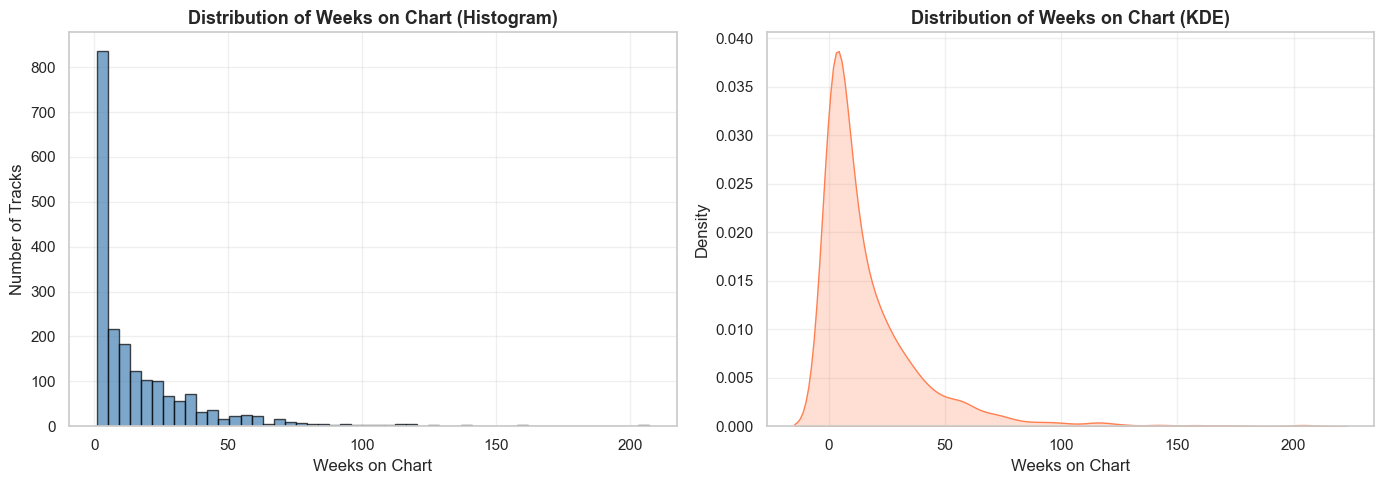


Distribution is right-skewed (Skewness: 3.15)


np.float64(3.153915346375899)

In [8]:
# Plot distribution of weeks on chart
plot_longevity_distribution(longevity_data)


### B. Compare Audio Features: Short-lived vs Long-lasting Hits

Define two groups:
- **Short-lived hits**: songs staying ≤ 4 weeks
- **Long-lasting hits**: songs staying ≥ 15 weeks

In [9]:
# Prepare groups for comparison
short_lived, long_lasting, comparison_data = prepare_longevity_groups(longevity_data)

print(f"Short-lived hits (≤4 weeks): {len(short_lived)} tracks")
print(f"Long-lasting hits (≥15 weeks): {len(long_lasting)} tracks")


Short-lived hits (≤4 weeks): 755 tracks
Long-lasting hits (≥15 weeks): 729 tracks


### Visualization 2: Audio Features Comparison (Boxplots)

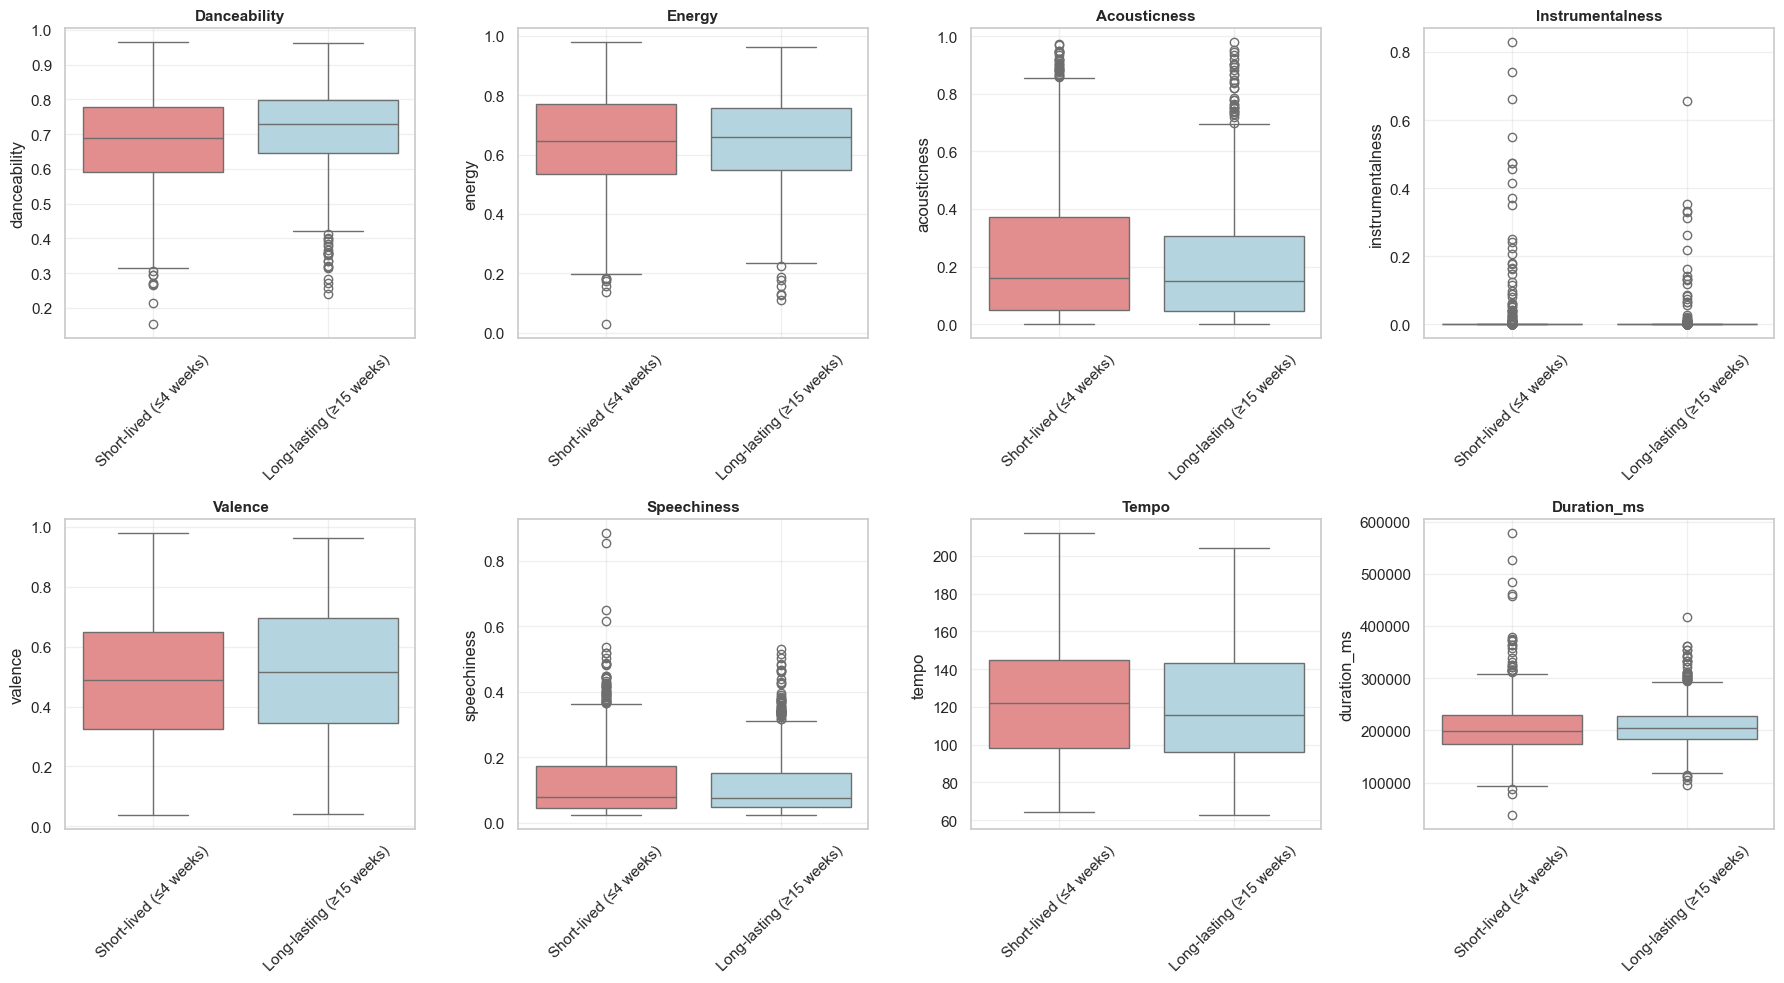


Summary Statistics:
danceability        : Short=  0.677, Long=  0.711, Diff=  0.034
energy              : Short=  0.640, Long=  0.644, Diff=  0.004
acousticness        : Short=  0.246, Long=  0.215, Diff= -0.032
instrumentalness    : Short=  0.011, Long=  0.005, Diff= -0.006
valence             : Short=  0.493, Long=  0.516, Diff=  0.023
speechiness         : Short=  0.130, Long=  0.119, Diff= -0.011
tempo               : Short=123.799, Long=121.303, Diff= -2.496
duration_ms         : Short=205907.473, Long=208364.075, Diff=2456.603


In [10]:
# Plot feature comparison boxplots
plot_longevity_feature_comparison(comparison_data, short_lived, long_lasting)


### C. Feature-Longevity Correlations

### Visualization 3: Correlation Heatmap (Features vs Weeks on Chart)

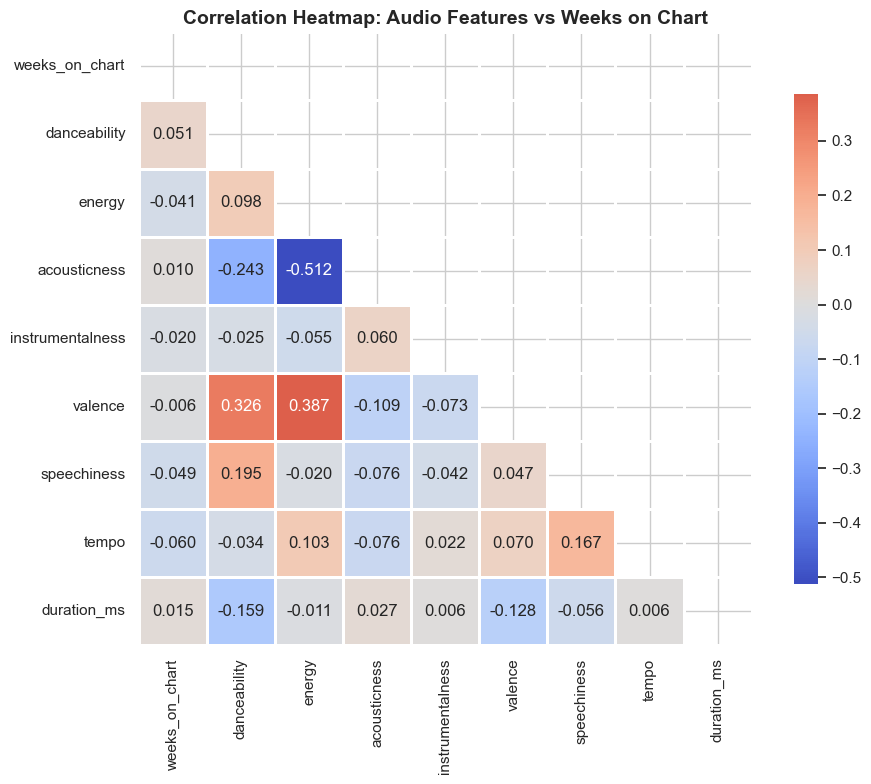


Correlations with Weeks on Chart:
danceability        0.050980
duration_ms         0.015335
acousticness        0.010278
valence            -0.005821
instrumentalness   -0.020033
energy             -0.041049
speechiness        -0.049220
tempo              -0.060228
Name: weeks_on_chart, dtype: float64


In [11]:
# Plot correlation heatmap
longevity_correlations = plot_longevity_correlations(longevity_data)


### D. Relationship Plots

### Visualization 4: Scatter Plots with Regression Lines (Top Correlated Features)

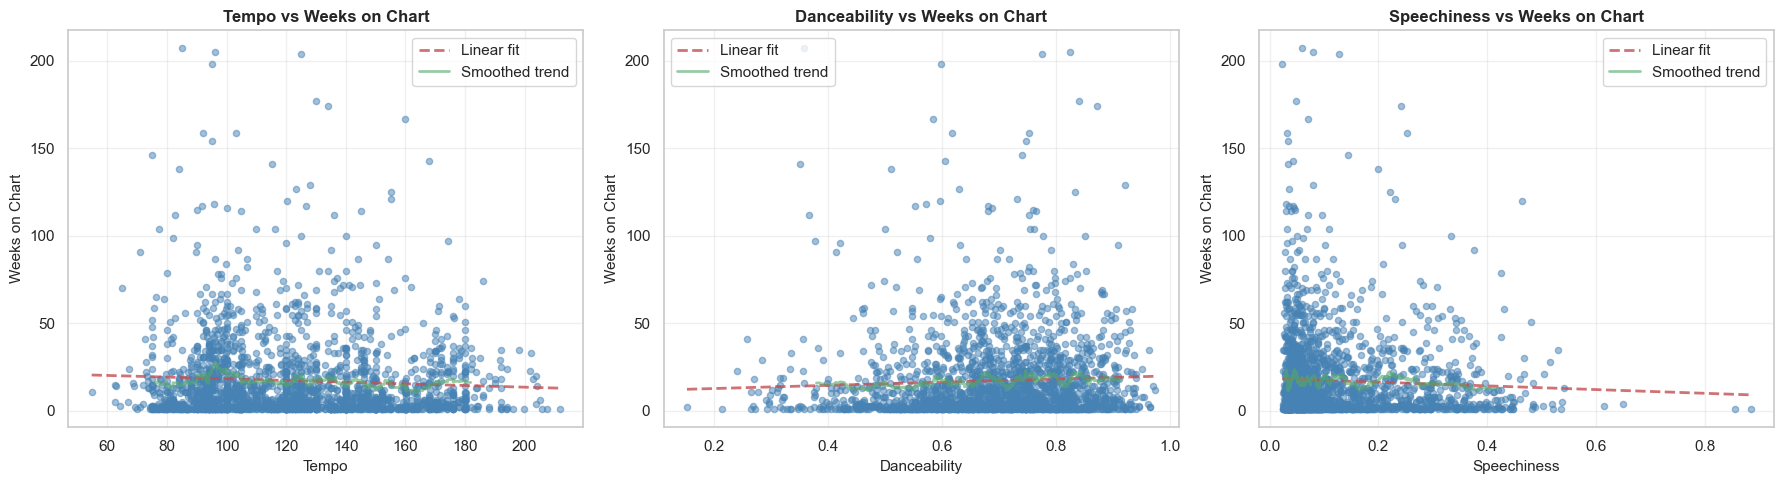


Top 3 features analyzed: tempo, danceability, speechiness


In [12]:
# Plot scatter plots with regression lines
plot_longevity_scatter_plots(longevity_data, longevity_correlations, n_features=3)


### E. Clustering Songs by Audio Profile

### Visualization 5: PCA 2D Cluster Plot

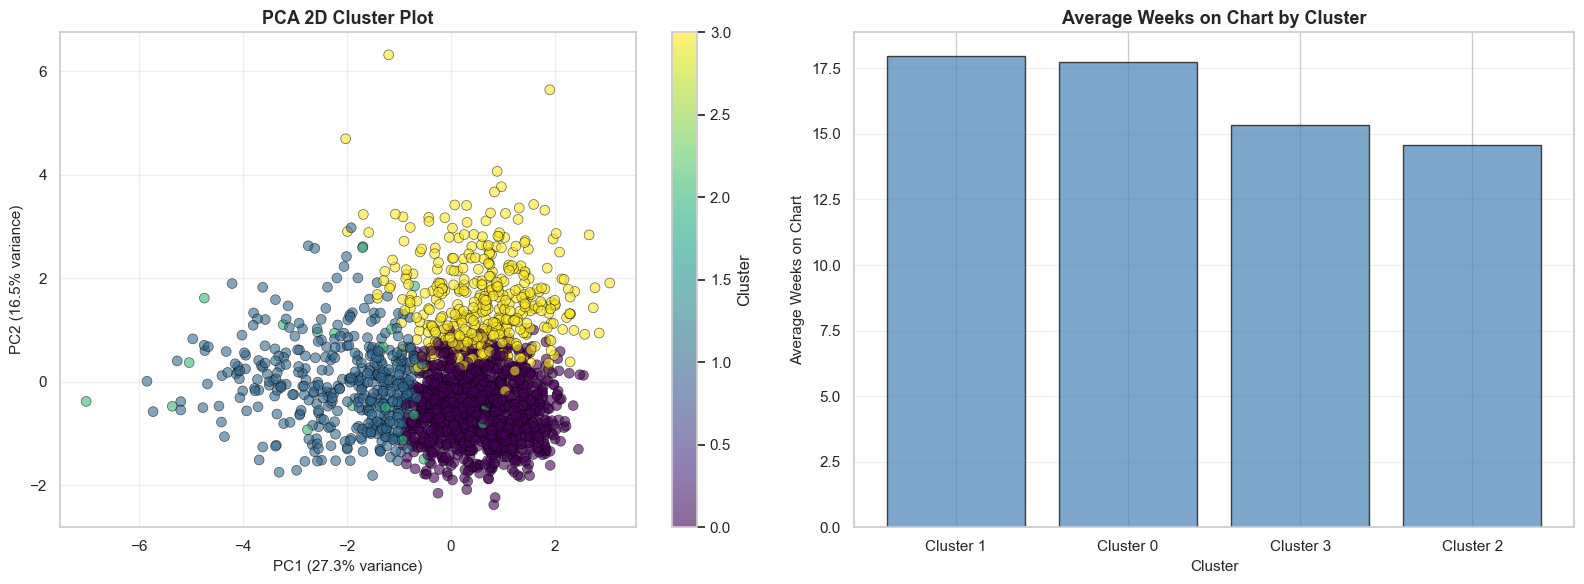


Cluster Characteristics:

Cluster 0:
  Average weeks on chart: 17.8
  Number of tracks: 1147
  Feature means:
    danceability: 0.716
    energy: 0.712
    acousticness: 0.148
    instrumentalness: 0.003
    valence: 0.569
    speechiness: 0.079
    tempo: 120.268

Cluster 1:
  Average weeks on chart: 18.0
  Number of tracks: 424
  Feature means:
    danceability: 0.578
    energy: 0.462
    acousticness: 0.498
    instrumentalness: 0.007
    valence: 0.326
    speechiness: 0.073
    tempo: 116.158

Cluster 2:
  Average weeks on chart: 14.6
  Number of tracks: 23
  Feature means:
    danceability: 0.648
    energy: 0.565
    acousticness: 0.311
    instrumentalness: 0.493
    valence: 0.403
    speechiness: 0.086
    tempo: 123.422

Cluster 3:
  Average weeks on chart: 15.3
  Number of tracks: 409
  Feature means:
    danceability: 0.750
    energy: 0.629
    acousticness: 0.181
    instrumentalness: 0.003
    valence: 0.510
    speechiness: 0.303
    tempo: 137.911


In [13]:
# Perform clustering and visualize
cluster_data = plot_longevity_clustering(longevity_data)


### F. Longevity Curves (Survival-Style Analysis)

### Visualization 6: Average Chart Rank Over Weeks by Feature Quantiles

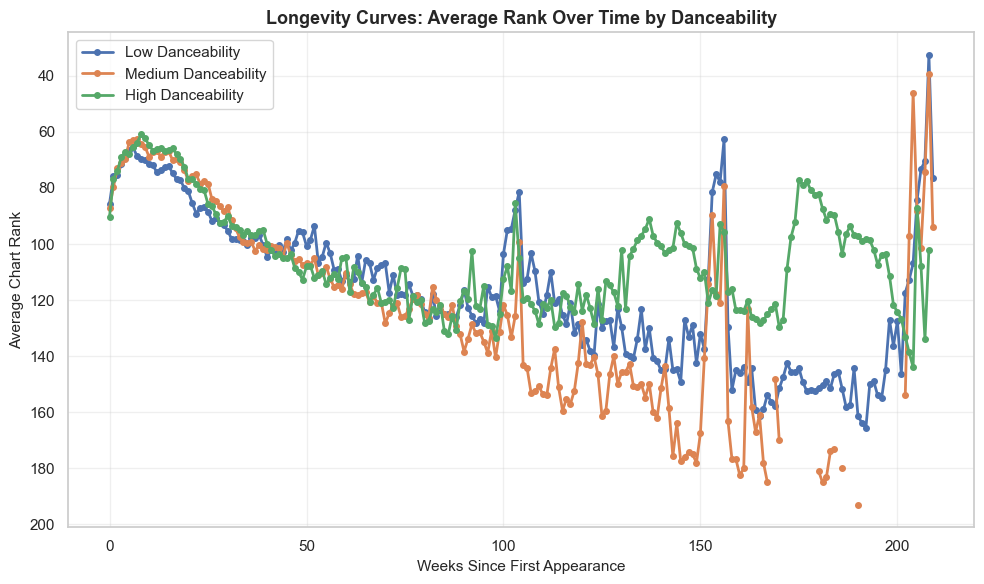

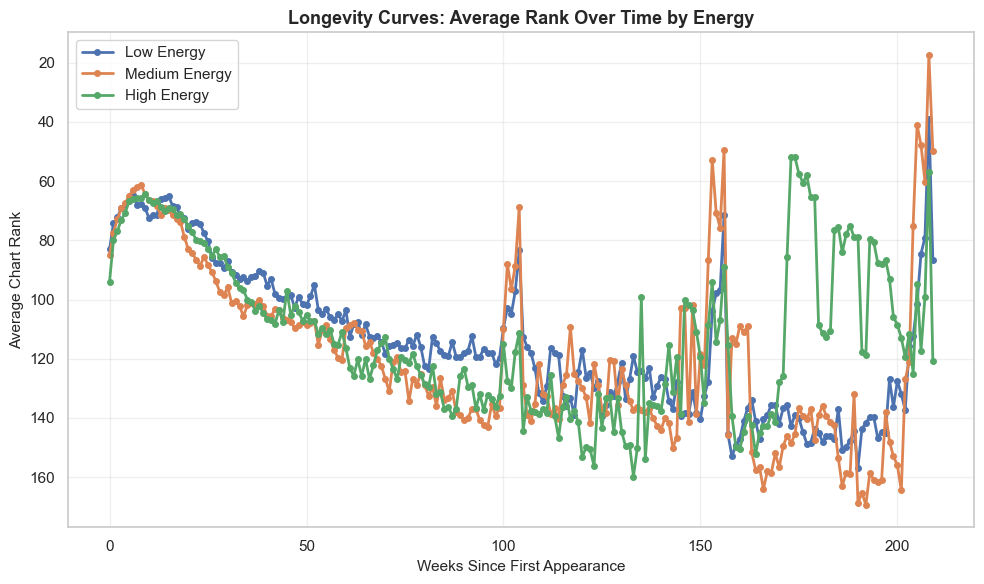


Longevity curves show how tracks decline over time.
Lower rank = better position (rank 1 is #1 on chart).


In [14]:
# Get track features for longevity curves
track_features = songs.groupby('track_id').first()[['danceability', 'energy']].reset_index()

# Plot longevity curves by danceability
plot_longevity_curves(songs, track_features, feature='danceability')

# Plot longevity curves by energy
plot_longevity_curves(songs, track_features, feature='energy')

print("\nLongevity curves show how tracks decline over time.")
print("Lower rank = better position (rank 1 is #1 on chart).")


## G. Machine Learning: Predicting Song Longevity

This section uses machine learning models to predict song longevity (weeks on chart) using only **non-temporal features** - the inherent characteristics of songs that don't depend on time or historical performance.

**Features used:**
- Audio characteristics: danceability, energy, acousticness, instrumentalness, valence, speechiness, tempo
- Metadata: duration_ms, explicit
- Artist count: number of artists per track

**Target:** Classification into longevity categories:
- **Short-lived** (≤4 weeks)
- **Medium** (5-14 weeks)
- **Long-lasting** (≥15 weeks)

In [15]:
from data_visualisation import prepare_longevity_features, train_longevity_classification_models
from sklearn.model_selection import train_test_split

# Prepare features for longevity prediction
X, y, feature_names, longevity_df = prepare_longevity_features(songs, track_appearances)

# Display class distribution
print("\nClass Distribution:")
print(longevity_df['longevity_category'].value_counts().sort_index())
print(f"\nTotal tracks: {len(X)}")
print(f"Features: {feature_names}")

# Split into train/test (random split since we're not using temporal features)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Longevity Prediction Data Preparation:
Total tracks: 2003
Features: ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness', 'tempo', 'duration_ms', 'explicit', 'num_artists']

Longevity category distribution:
longevity_category
Long      729
Medium    519
Short     755
Name: count, dtype: int64

Feature matrix shape: (2003, 10)

Class Distribution:
longevity_category
Long      729
Medium    519
Short     755
Name: count, dtype: int64

Total tracks: 2003
Features: ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness', 'tempo', 'duration_ms', 'explicit', 'num_artists']

Train set: 1602 samples
Test set: 401 samples


In [16]:
# Train longevity classification models
longevity_results = train_longevity_classification_models(
    X_train, y_train, X_test, y_test, feature_names
)

LONGEVITY CLASSIFICATION MODELS (Multi-class)
Classes: 0=Short (≤4 weeks), 1=Medium (5-14 weeks), 2=Long (≥15 weeks)
Training samples: 1602, Test samples: 401

1. Logistic Regression (Multi-class):
   Accuracy: 0.4115
   Precision (macro): 0.2757
   Recall (macro): 0.3701
   F1-Score (macro): 0.3158
   ROC-AUC (macro): 0.5390

2. Random Forest Classifier (Multi-class):
   Accuracy: 0.3616
   Precision (macro): 0.3032
   Recall (macro): 0.3301
   F1-Score (macro): 0.3052
   ROC-AUC (macro): 0.5210

3. XGBoost: Not available (install with: pip install xgboost)

Detailed Classification Report (LR - Best Model):
              precision    recall  f1-score   support

       Short       0.41      0.58      0.48       151
      Medium       0.00      0.00      0.00       104
        Long       0.41      0.53      0.46       146

    accuracy                           0.41       401
   macro avg       0.28      0.37      0.32       401
weighted avg       0.31      0.41      0.35       401



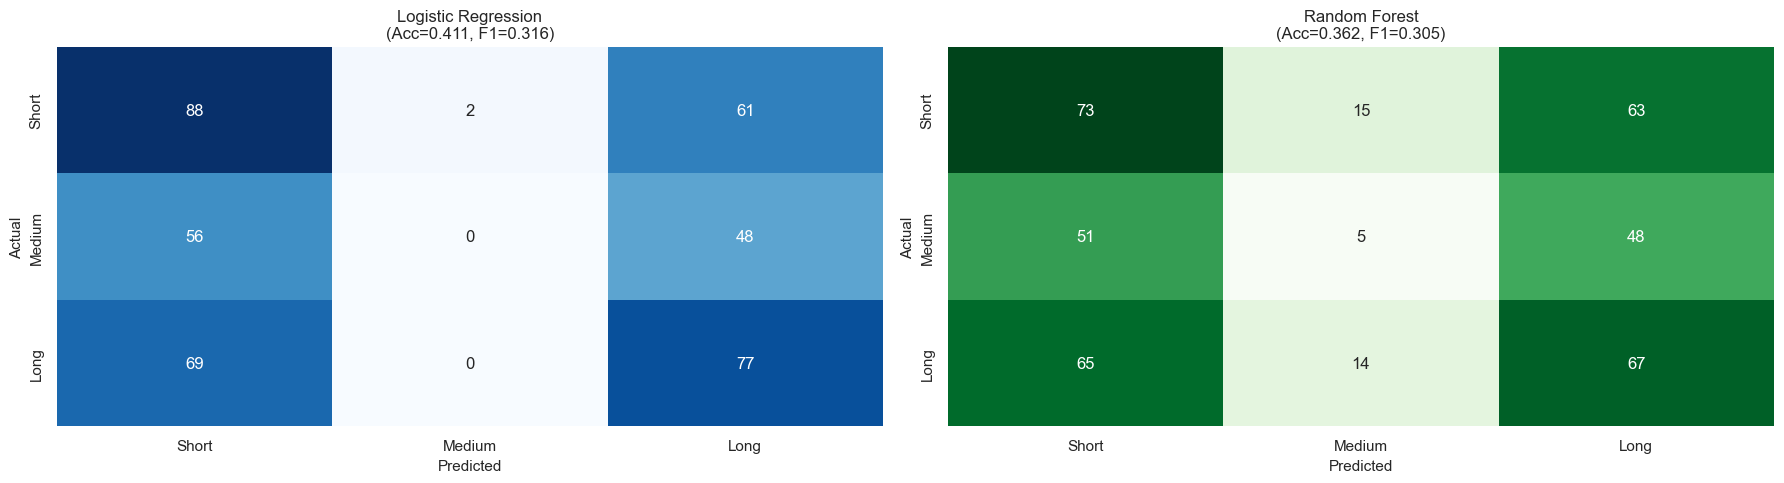

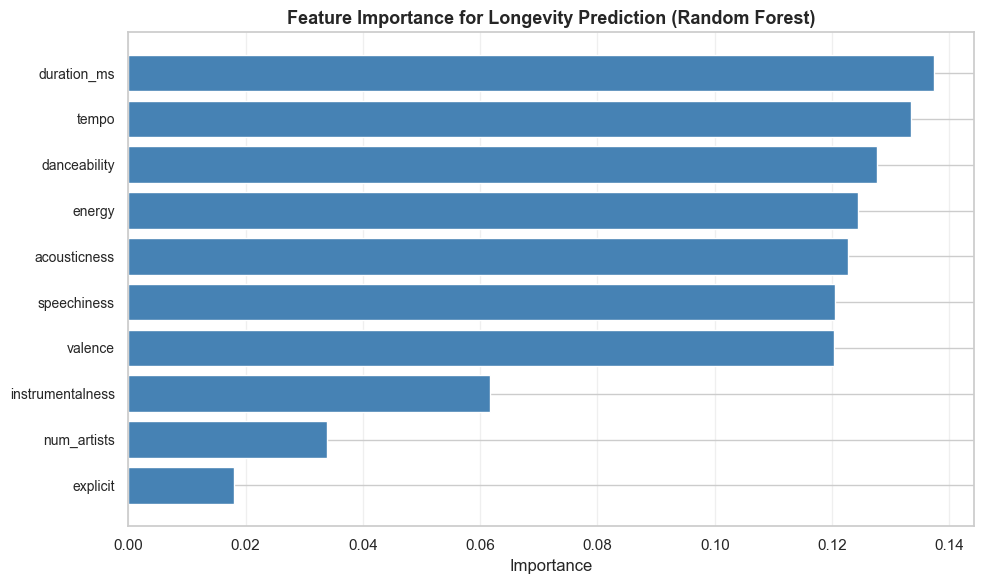


Top Features for Longevity Prediction:
         feature  importance
     duration_ms    0.137317
           tempo    0.133520
    danceability    0.127703
          energy    0.124402
    acousticness    0.122709
     speechiness    0.120428
         valence    0.120326
instrumentalness    0.061622
     num_artists    0.033909
        explicit    0.018064


In [17]:
# Plot ML longevity prediction results
feature_importance = plot_longevity_ml_results(longevity_results, y_test, feature_names)


In [18]:
# Summary of findings
print("=" * 60)
print("LONGEVITY PREDICTION SUMMARY")
print("=" * 60)

# Find best model
results = longevity_results['results']
best_model_name = max(results.keys(), key=lambda k: results[k]['acc'] if results[k] else 0)
best_model_results = results[best_model_name]

print(f"\nBest Model: {best_model_name.upper()}")
print(f"  Accuracy: {best_model_results['acc']:.4f}")
print(f"  F1-Score (macro): {best_model_results['f1']:.4f}")

# Feature importance insights
if feature_importance is not None:
    top_features = feature_importance.head(5)
    print(f"\nTop 5 Most Important Features:")
    for idx, row in top_features.iterrows():
        print(f"  {row['feature']:20s}: {row['importance']:.4f}")

print("\n" + "=" * 60)
print("Key Insights:")
print("=" * 60)
print("1. The models predict longevity using only inherent song characteristics")
print("2. No temporal or historical features are used (no streams, dates, etc.)")
print("3. This allows prediction before a song even appears on charts")
print("4. Feature importance reveals which audio characteristics matter most")
print("5. The model can help identify what makes songs last longer on charts")


LONGEVITY PREDICTION SUMMARY

Best Model: LR
  Accuracy: 0.4115
  F1-Score (macro): 0.3158

Top 5 Most Important Features:
  duration_ms         : 0.1373
  tempo               : 0.1335
  danceability        : 0.1277
  energy              : 0.1244
  acousticness        : 0.1227

Key Insights:
1. The models predict longevity using only inherent song characteristics
2. No temporal or historical features are used (no streams, dates, etc.)
3. This allows prediction before a song even appears on charts
4. Feature importance reveals which audio characteristics matter most
5. The model can help identify what makes songs last longer on charts


# Key audio features for songs in the charts

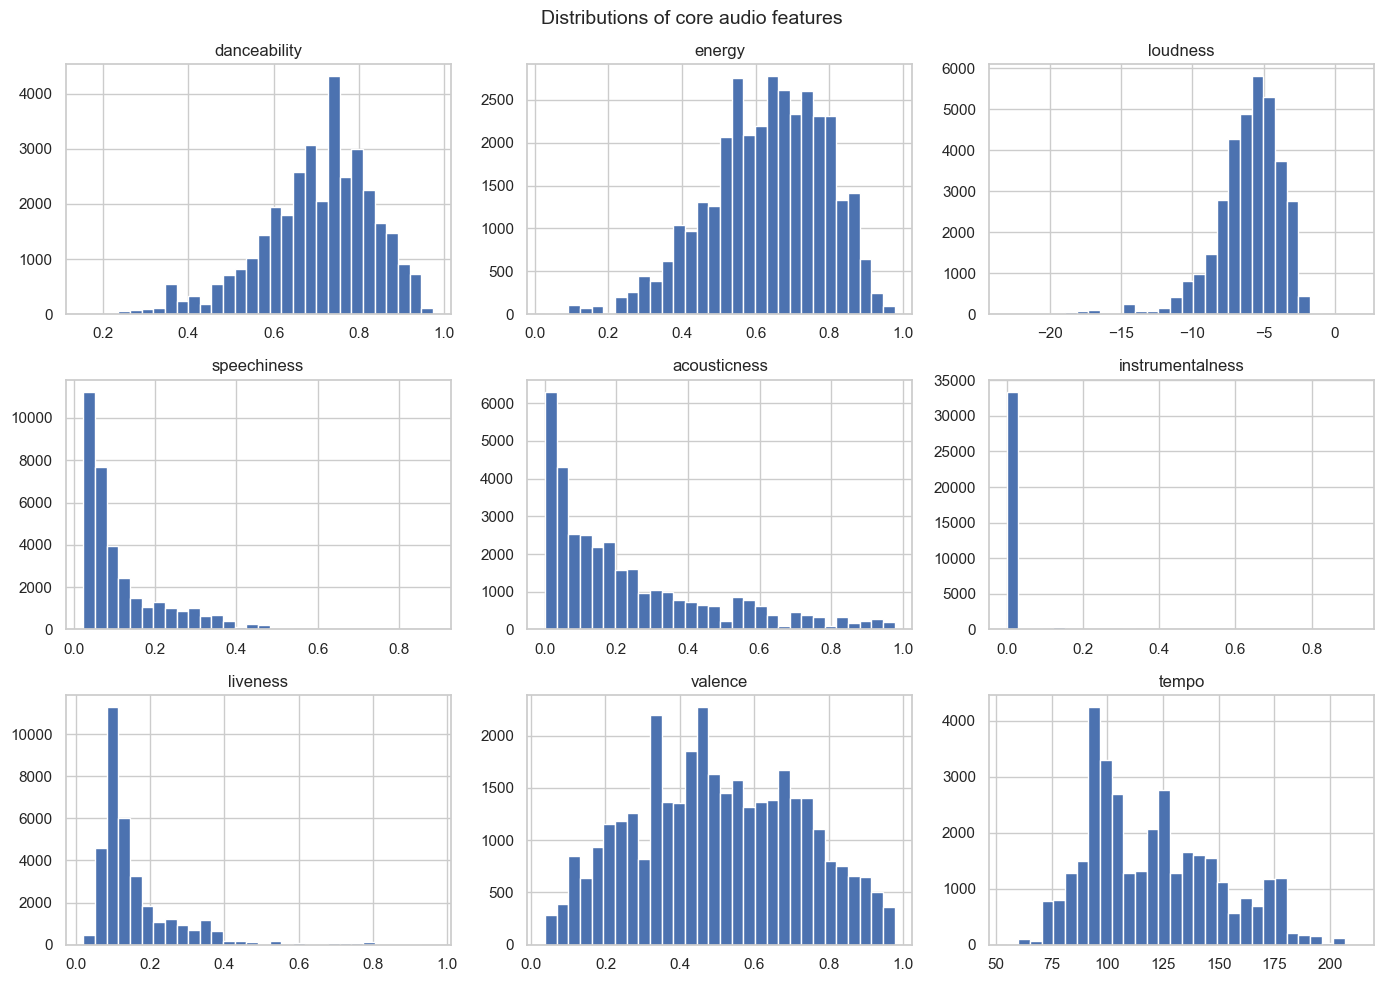

In [19]:
# Basic distribution plots for key audio features within the top songs
numeric_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

plot_audio_feature_distributions(songs, numeric_cols)


In [20]:
# Stream distribution by audio features
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']



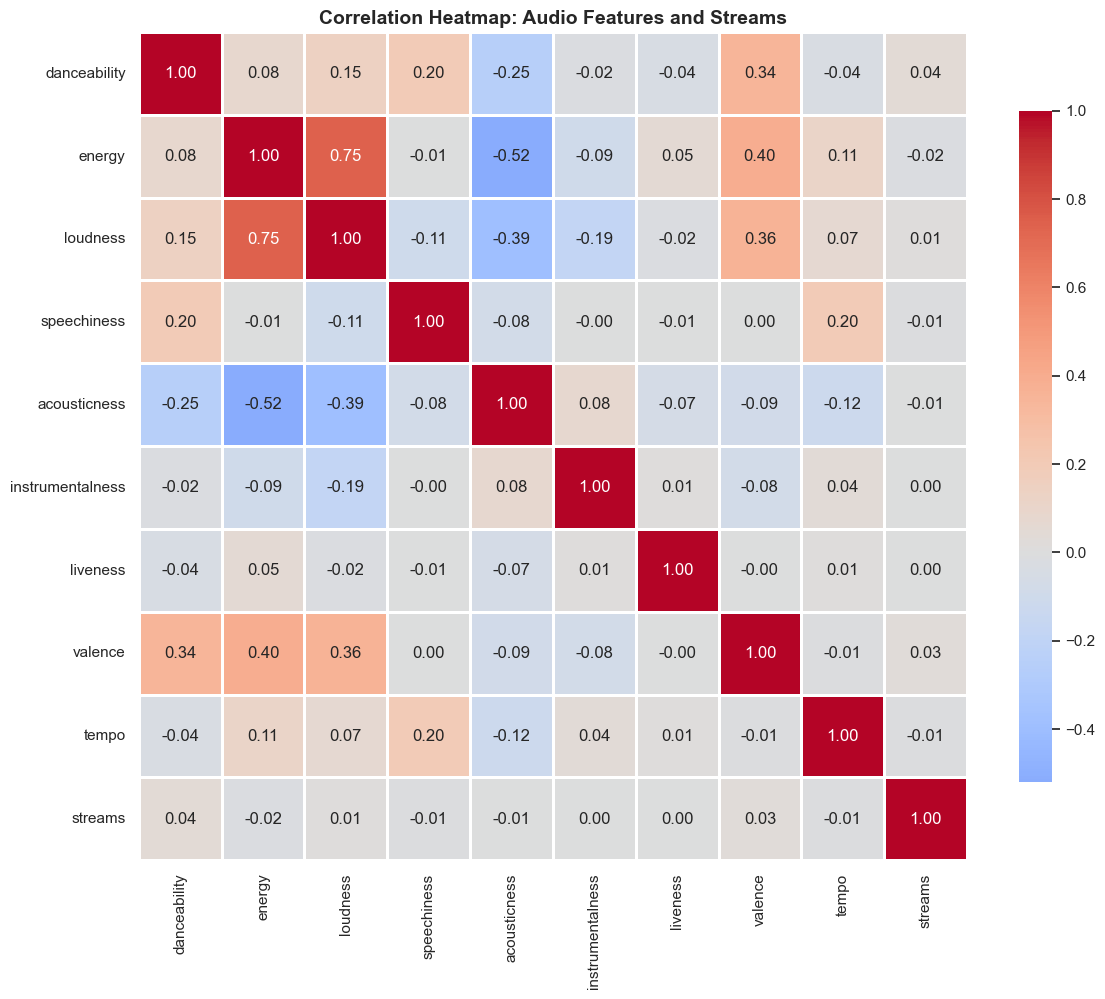


Top correlations with streams:
danceability        0.040631
valence             0.031191
loudness            0.012354
instrumentalness    0.002566
liveness            0.001698
acousticness       -0.007674
speechiness        -0.009800
tempo              -0.014455
energy             -0.016455
Name: streams, dtype: float64


In [21]:
# Correlation heatmap between audio features and streams
plot_correlation_heatmap(songs, audio_features)

# Show top correlations with streams
stream_correlations = get_stream_correlations(songs, audio_features)
print("\nTop correlations with streams:")
print(stream_correlations)


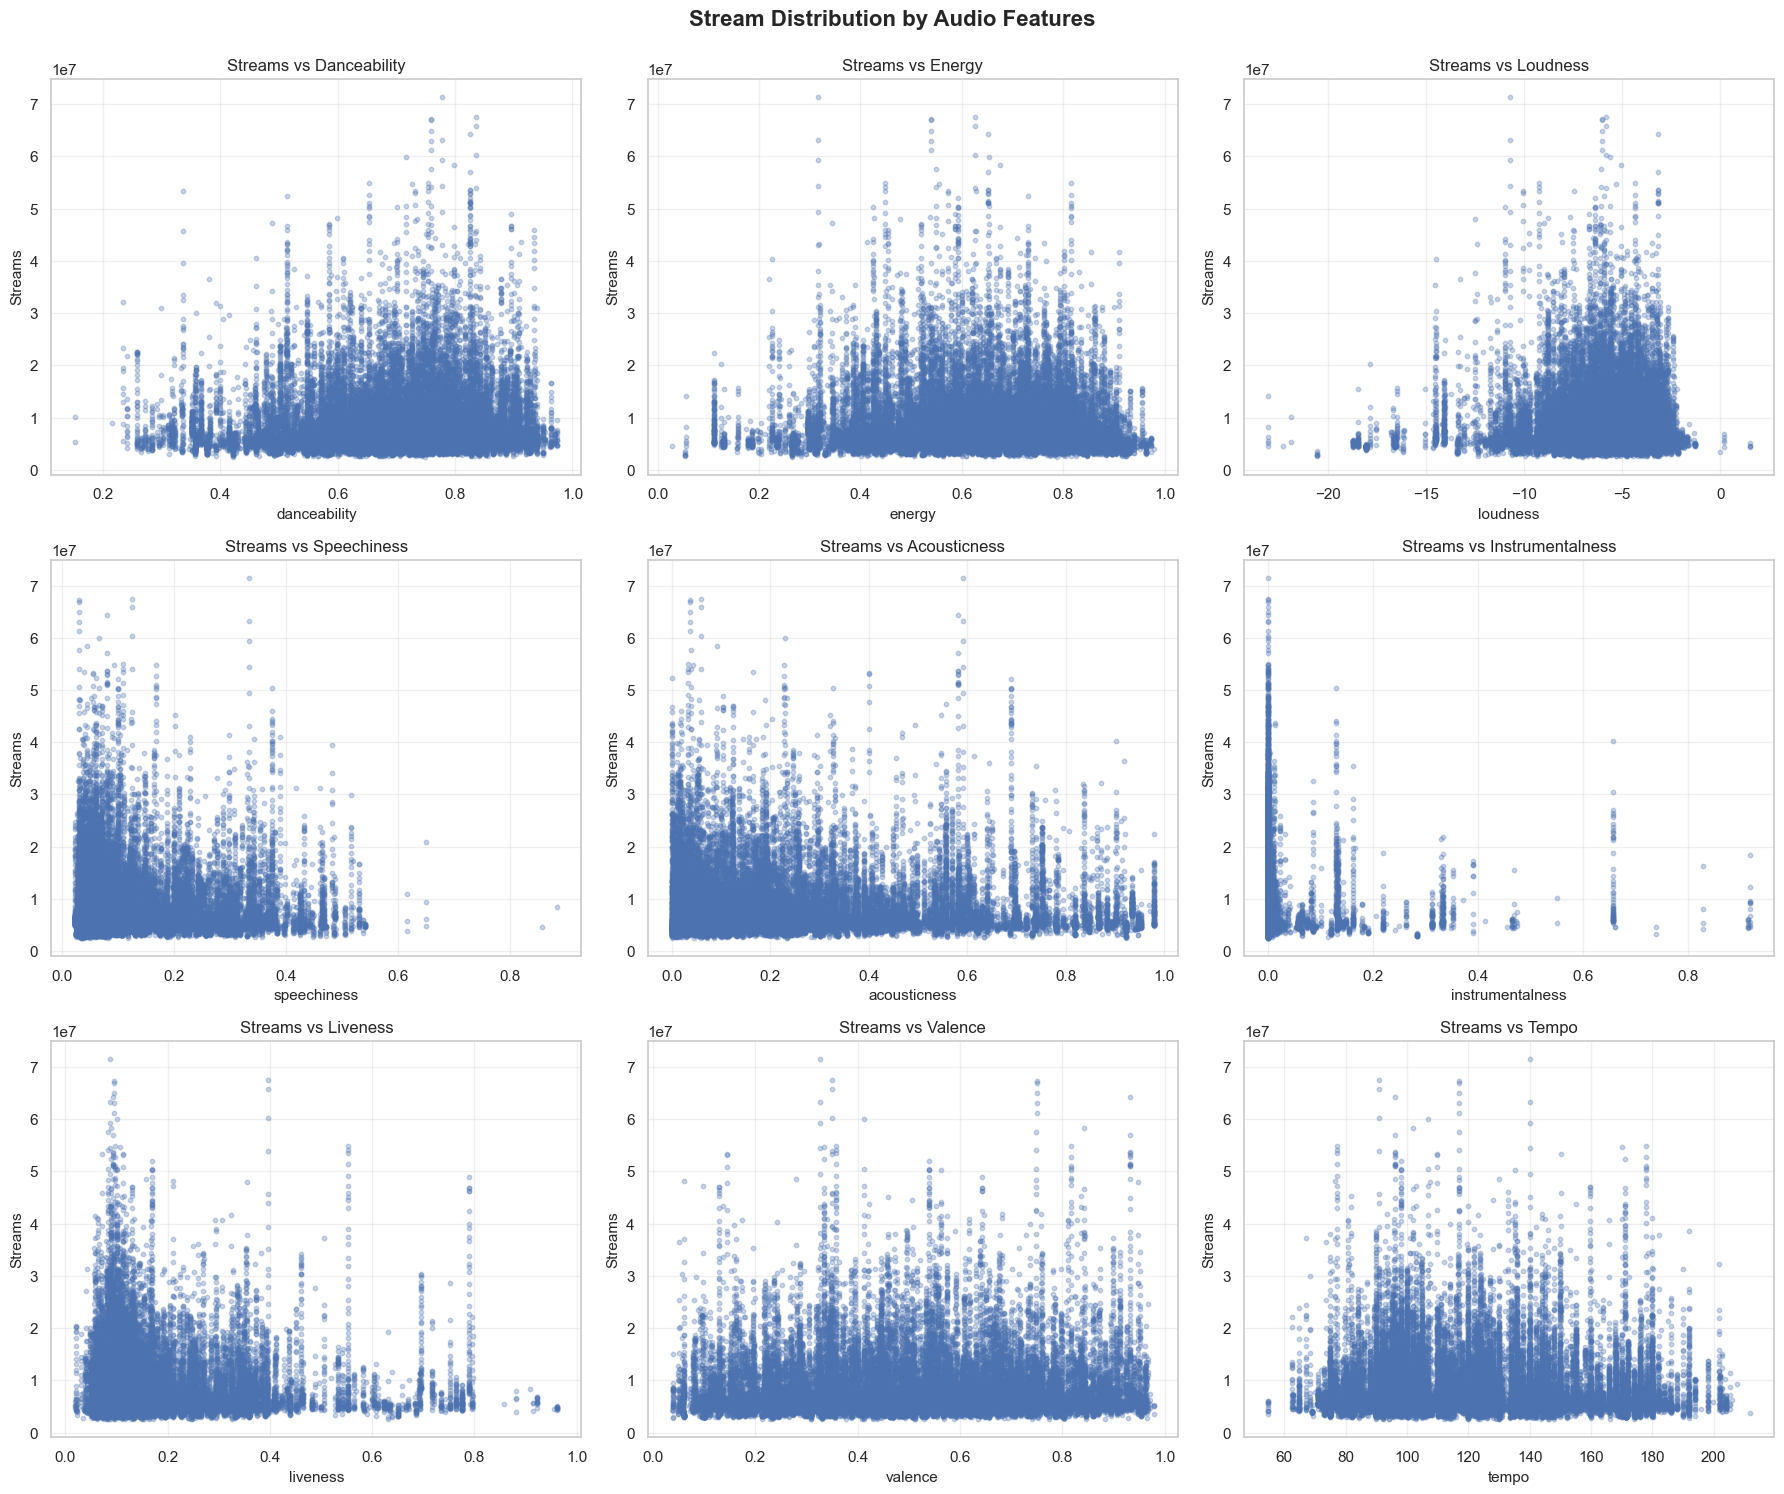

In [22]:

plot_streams_vs_features(songs, audio_features)


# Key Insights